# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.


## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Загрузим датасет, необходимый для исследования. Введём разделитель \t

In [3]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('C:/Users/Пользователь/Downloads/real_estate_data.csv', sep='\t')

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Дата сет сожержит 23 699 записи. В ряде столбцов присутсвуют пропущенные значения. Для столбца 'first_day_exposition' лучше изменить тип данных. 

## Предобработка данных

Во-первых, поменяем тип данных в столбце 'first_day_exposition', чтобы было проще работать с датой и временем. 

In [5]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

Во-вторых, достаточно много пропущенных значений в столбце 'ceiling_height' (высота потолка). Есть данные только по 61% квартир. Кроме того, есть неправдоподобно маленькие и большие значения.
Предположим, что нормальным является величина потолка от 2.2 до 3.5 метров. Посмотри, сколько квартир неудовлетворяют этому условию.

In [6]:
data.query('ceiling_height < 2.2 or ceiling_height > 3.5').count()

total_images            318
last_price              318
total_area              318
first_day_exposition    318
rooms                   318
ceiling_height          318
floors_total            318
living_area             299
floor                   318
is_apartment             56
studio                  318
open_plan               318
kitchen_area            292
balcony                 133
locality_name           316
airports_nearest        284
cityCenters_nearest     287
parks_around3000        287
parks_nearest           210
ponds_around3000        287
ponds_nearest           208
days_exposition         248
dtype: int64

Для выборки в 23 699 значенй 318 объектов - это менее 2%. Можем пропустить эти значения, они не сильно исказят наше исследования и попадают в диапозон статистической погрешности. Прокущенные значения в этом столбце заменим на средние. 

In [7]:
ceiling_height_avg = data['ceiling_height'].mean()
data['ceiling_height'] = data['ceiling_height'].fillna(value = ceiling_height_avg)

В-третьих, пропущенные значения в столбце 'is_apartment' приведём к булевым.

In [8]:
data['is_apartment'] = data['is_apartment'].fillna(value = False)   
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

В-четвёртых, заменим пропущенные значения в столбце 'balcony' на целочисленные. Если стоит пропуск, логично предположить, что балкона нет.

In [9]:
data['balcony'] = data['balcony'].fillna(0)  

В-пятых, поменяем тип данных в столбце 'last_price'.


In [10]:
data['last_price'] = data['last_price'].astype('int')

В-шестых, поменяем значения в столбце 'days_exposition' на целочисленный и заполним пропуски. 


In [11]:
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')

Пропущенные значения в столбце 'floors_total' заполнять не будем. Можно предположить, что они были не указаны, потому что значение в столбце 'floor'  является последним. 
Пропущенные значения в столбце 'living_area' также зполнять не будем. Это может сказаться на наших дальнейших вычеслениях ,необходимых для проведения исследования в разделах №№ 3 и 4. Тоже самое справедливо и для отсуствующих значений в столбце 'kitchen_area'.
Мы также не будем заполнять пропуски для столбцов, характеризующих расстояние до различных объектов. Заполнять эти пропуски методом mean() было бы не правильно, т.к. это может сильно исказить полученные данные.

__Вывод__

- Пропущенные и искаженные значения могли появится в следствии человеческого фактора.

- Некоторые данные, напрмер "расстояние до аэропорта" и "количество балконов" могли быть не заполнены в виду их неактуальности.

- Пропуски в других столбцах могли стать следствием потери информации в результате технического сбоя, например, при выгрузке данных. 

## Расчёты и добавление результатов в таблицу

Добавим в таблицу столбец с расчётом по стоимости квадратного метра недвижимости. Для это в новый столбец запишим отношение в данных в столбце 'last_price' к 'total_area' 

In [12]:
data['square_metre_price'] = data['last_price'] / data['total_area']

Добавим в таблицу столбцы с днём, месяцем и годом публикации.

In [13]:
data['day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

Добавим в датафрейм индикатор этажей. Для этого напишим функцию, которая будет присваивать значения: 'Первый','Последний', 'Другой'. 

In [14]:
def total_floor_category(data):
    floor = data['floor']
    if floor == 1:
        return 'Первый'
    if floor == data['floors_total']:
        return 'Последний'
    else:
        return 'Другой'

data['floor_category'] = data.apply(total_floor_category, axis=1)

Посчитаем отношение жилой площади к общей и кухни к общей. Добавим эти результаты в датафрейм.

In [15]:
data['living_space_ratio'] = data['living_area'] / data['total_area']
data['kithcen_space_ratio'] = data['kitchen_area'] / data['total_area']

__Вывод__

В датафрейм добавлены значения, которые понадобятся нам в дальнейщем исследовании.

## Исследовательский анализ данных

1. Изучим следующие параметры из датафрейма: площадь, цена, число комнат, высота потолков. Для наглядности составим гистограмму для каждого параметра.

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

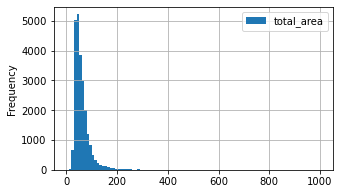

In [16]:
data.plot(y = 'total_area', kind='hist', bins=100, grid=True, figsize=(5,3), range=(0,1000))
data['total_area'].describe()

__Площадь / total_area__

Среднее значение и второй квартиль имеют близкие значения. Показатель стандартного отклонения достаточно высокий. Это может быть объянено наличием аномальных - очень больших или очень маленьких, по отношению к средней величине - значений. Если учеть, что речь идёт о рынке недвижимости, где могут продаваться и комнаты в коммунальных квартирах и отдельные дома, то, возможно,  такие отклонения имеют место быть. Дальнейшие исследования покажут... 

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

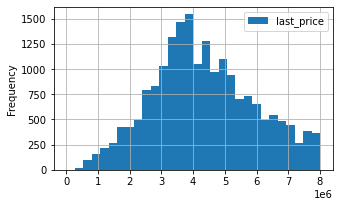

In [17]:
data.plot(y = 'last_price', kind='hist', bins=30, grid=True, figsize=(5,3), range=(0,8000000))
data['last_price'].describe()

__Цена продажи / last_price__

На графике видими пиковое значение на отметке около 4 миллионов. Это приблизительно совпадает со значениями второго квартиля. Видим достаточно высокое значение стандартного отклонения, что является свидетельством очень большого разброса значений. 

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

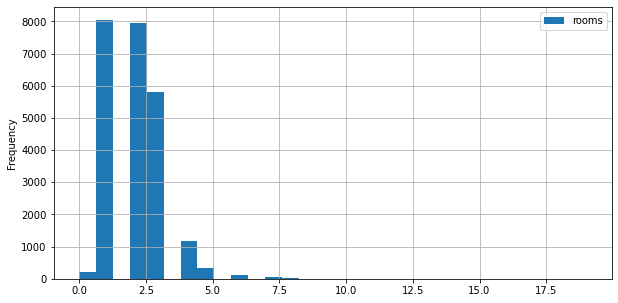

In [18]:
data.plot(y = 'rooms', kind='hist', bins=30, grid=True, figsize=(10,5))
data['rooms'].describe()

__Число комнат / rooms__

резульатыт выглядят достаточно правдоподобными: большинстов объектов недвижимости в выборке - это 1-о,2-х и 3-х комнатные квартиры. 


count    23699.000000
mean         2.771499
std          0.986523
min          1.000000
25%          2.600000
50%          2.771499
75%          2.771499
max        100.000000
Name: ceiling_height, dtype: float64

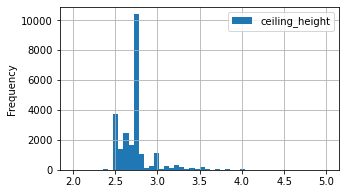

In [19]:
data.plot(y = 'ceiling_height', kind='hist', bins=50, grid=True, figsize=(5,3), range=(2,5))
data['ceiling_height'].describe()

__Высота потолка / ceiling_height__

Как видим на графике, большинство квартир имеет высоту потолка 2,77 метра - это результат изменения нами пропущенных значений на стадии предоброботки данных. Однако эти значения, в целом, не кажутся аномальными, хотя в данных есть явно завышенные и заниженные значения.

__Вывод по гистограммам__

Типичный объект недвижимости, согласно нашей выборке, это - двухкомнатная квартира площадью 60,3 квадратных метра, с пвысотой потолка в 2.77 метра и стоимсотью в 6,54 млн.


2. Далее расчитаем среднее время продажи квартиры и составим гистограмму.

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

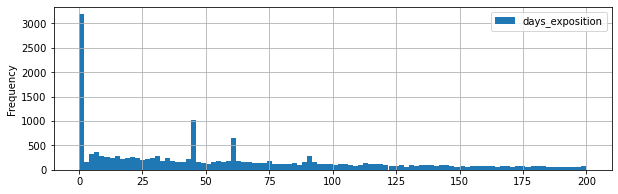

In [20]:
data.plot(y = 'days_exposition', kind='hist', bins=100, grid=True, figsize=(10,3), range=(0,200))
data['days_exposition'].describe()

Наблюдаем аномально высокие значения на 45, 60 и 90 день. Сомнительно, что квартиры продаются в такой пропорции на 45, 60 или 90 день с момента публикации объявлений. Возможно, это связано с како-либо спецификой процесса продаж. Например, с со снятием объявления или с публикацией нового обявления со сниженной ценой. Кроме того, уберём значения, которым мы присвоили значение "0". 
В идеале, нужно было бы уточнить эту специфику у владельца датафрейма (заказчика).

In [21]:
data[data['days_exposition'] == 45].count()

total_images            880
last_price              880
total_area              880
first_day_exposition    880
rooms                   880
ceiling_height          880
floors_total            880
living_area             546
floor                   880
is_apartment            880
studio                  880
open_plan               880
kitchen_area            540
balcony                 880
locality_name           879
airports_nearest        428
cityCenters_nearest     428
parks_around3000        428
parks_nearest           151
ponds_around3000        428
ponds_nearest           201
days_exposition         880
square_metre_price      880
day                     880
month                   880
year                    880
floor_category          880
living_space_ratio      546
kithcen_space_ratio     540
dtype: int64

In [22]:
data[data['days_exposition'] == 60].count()

total_images            538
last_price              538
total_area              538
first_day_exposition    538
rooms                   538
ceiling_height          538
floors_total            538
living_area             350
floor                   538
is_apartment            538
studio                  538
open_plan               538
kitchen_area            359
balcony                 538
locality_name           538
airports_nearest        464
cityCenters_nearest     465
parks_around3000        465
parks_nearest           184
ponds_around3000        465
ponds_nearest           231
days_exposition         538
square_metre_price      538
day                     538
month                   538
year                    538
floor_category          538
living_space_ratio      350
kithcen_space_ratio     359
dtype: int64

In [23]:
data[data['days_exposition'] == 90].count()

total_images            204
last_price              204
total_area              204
first_day_exposition    204
rooms                   204
ceiling_height          204
floors_total            201
living_area             140
floor                   204
is_apartment            204
studio                  204
open_plan               204
kitchen_area            147
balcony                 204
locality_name           203
airports_nearest        188
cityCenters_nearest     189
parks_around3000        189
parks_nearest           114
ponds_around3000        189
ponds_nearest           117
days_exposition         204
square_metre_price      204
day                     204
month                   204
year                    204
floor_category          204
living_space_ratio      140
kithcen_space_ratio     147
dtype: int64

Выбросы в сумме составляют 6.8% от вех результатов.

3. Уберём аномальные значения и посомтрим, как изменится распределение. 

In [24]:
good_data = data.query('days_exposition != 60 and days_exposition != 0 and days_exposition != 45 and days_exposition != 90')


count    18896.000000
mean       191.640188
std        225.707795
min          1.000000
25%         41.000000
50%        110.000000
75%        252.000000
max       1580.000000
Name: days_exposition, dtype: float64

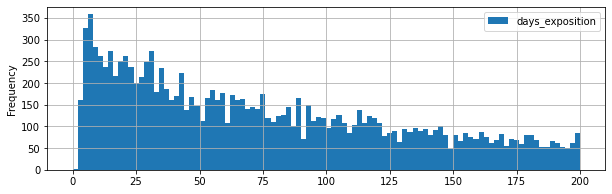

In [25]:
good_data.plot(y='days_exposition', kind='hist', bins=100, grid=True, figsize=(10,3), range=(0,200))
good_data['days_exposition'].describe()

__Время продажи__

Распределение соотвествует кривой Пуассона. В среднем квартиры продаются 109 дней. Если сделка была совершенна не позднее 33 дней с момента публикации объявления, то её можно считать очень быстрой. Если позже 165 дня - то аномально долгой. 

4. Определим, какие факторы больше всего влияют на стоимость неввижимости. 

Для этого найдём коэффициент корреляции, запшем в отдельную переменную и выведем на экран по столбцу 'square_metre_price' в порядке убывания.

In [26]:
corr_data = good_data.corr()
corr_data['square_metre_price'].sort_values(ascending=False)

square_metre_price     1.000000
last_price             0.739906
kitchen_area           0.392821
total_area             0.309880
living_area            0.229201
ponds_around3000       0.179627
parks_around3000       0.171087
kithcen_space_ratio    0.159407
floors_total           0.143467
floor                  0.128338
total_images           0.119113
ceiling_height         0.106335
rooms                  0.054711
is_apartment           0.044029
days_exposition        0.042078
balcony                0.026492
studio                 0.018617
parks_nearest          0.012024
open_plan              0.005734
month                  0.001112
day                   -0.003966
year                  -0.004969
airports_nearest      -0.041207
ponds_nearest         -0.091908
living_space_ratio    -0.145962
cityCenters_nearest   -0.318574
Name: square_metre_price, dtype: float64

__Интерпретация значений корреляции__

- Видим высокую прямую корреляцию между стоимостью квадратного метра и стоимостью объекта. В дорогих объектах дорогой квадрат. Логично...

- Умеренная прямая корреляция наблюдается между площадью кухни и общей площадью, с одной стороны, и стоимостью квадрата с другой. Чем больше площадь(общая или кухни), тем выше цена.

- Умеренная обратная корреляция существует между стоимостью квадрата и близостью центра города. Чем меньше расстояние о центра, тем выше стоимость квадратного метра. 

- Слабая прямая коррелция также наблюдается с такими характеристиками, как: жилая площадь, наличие в радиусе 3 км парков и прудов, отношением площади кухни к площади всего объекта, этажностью дома, этажом объекта, количеством изображений, высотой потолков.

- Слабая обратная корреляция наблюдается между стоимостью квадратного метра и отношением жилой площади к площади всей квартиры.

Построим графики для ключевых параметров. 
Для отношения площади объекта к стоимости квадратного метра.

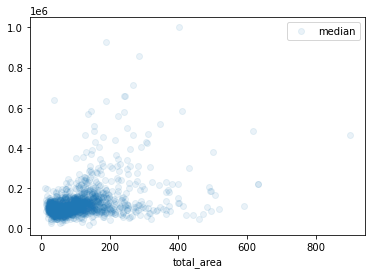

In [27]:
pivot_total_area = data.pivot_table(index='total_area', values='square_metre_price', aggfunc=['count', 'mean', 'median'])
pivot_total_area.columns = ['count', 'mean', 'median']
pivot_total_area.plot(y='median', style= 'o', alpha = 0.09);

График подтверждает, что зависимость, скорее, слабая.

Составим график для иллюстрации взаимосвязи стоимости квадртаного метра и количества комнат. Поскольку объектов мнго, количество комнат у них разное, учтём только те варианты, которые будут встречаться в сводной таблице свыше 50 раз.

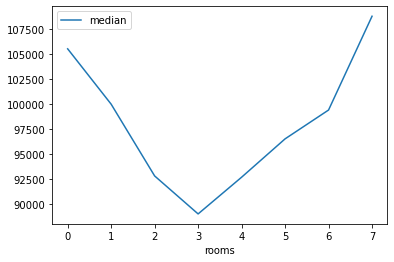

In [28]:
pivot_rooms = data.pivot_table(index='rooms', values='square_metre_price', aggfunc=['count', 'mean', 'median'])
pivot_rooms.columns = ['count', 'mean', 'median']
pivot_rooms.query('count > 50').plot(y='median');

Наблюдаем на графике интересную картину. Стоимость квадрата в однушках одна из самых высоких, почти как в "элитных" квартирах.

В "трёшках" самый дешёвый квадрат.

Стоимость квадрата в объектах с 4-мя и более комнатами начинает расти. 

Посмотрим на графике как меняется стоимость квадрата в зависимости удалённости от центра.

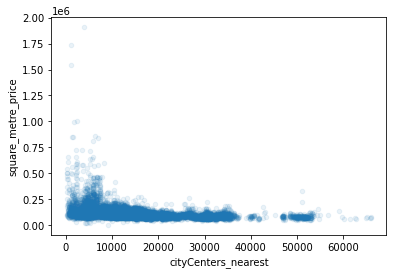

In [29]:
data.plot(x='cityCenters_nearest', y='square_metre_price', kind='scatter', alpha=0.09);

На графике видим обратную слабую зависимость стоимости квадрата по мере продвижения к центру. 

Отдельно определим, как на стоимость недвижимости влияет этажность. 

,count,median
,square_metre_price,square_metre_price
floor_category,,
Другой,14043,97222.222222
Первый,2256,80998.442368
Последний,2597,88630.806846


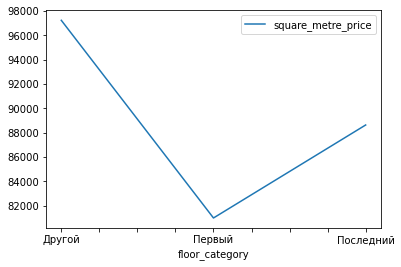

In [30]:
pivot_floor_category = good_data.pivot_table(index = 'floor_category', values = 'square_metre_price', aggfunc = ['count','median'])
pivot_floor_category.plot(y='median')
pivot_floor_category

Теперь посчитаем взаимосвязь стоимости квадратного метра и времени подачи заявления: для дня недели, месяца и года.

,count,median
,square_metre_price,square_metre_price
day,,
0,2820,94282.687651
1,3356,94875.448557
2,3136,94852.579920
3,3508,94805.194805
4,3265,94102.564103
5,1498,93310.897215
6,1313,93333.333333


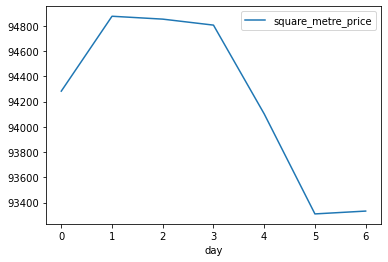

In [31]:
pivot_day = good_data.pivot_table(index = 'day', values = 'square_metre_price', aggfunc = ['count','median'])
pivot_day.plot(y='median')
pivot_day

,count,median
,square_metre_price,square_metre_price
month,,
1,1141,95454.545455
2,2055,94680.851064
3,1837,93600.000000
4,1442,93198.096001
5,1066,93317.757009
6,1544,93033.367037
7,1427,94117.647059
8,1500,95801.093067


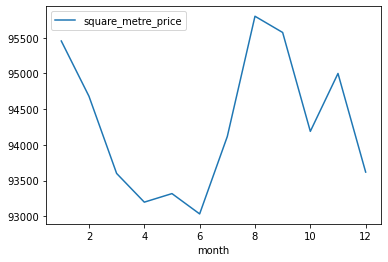

In [32]:
pivot_month = good_data.pivot_table(index = 'month', values = 'square_metre_price', aggfunc = ['count','median'])
pivot_month.plot(y='median')
pivot_month

,count,median
,square_metre_price,square_metre_price
year,,
2014,119,105157.894737
2015,1121,92785.714286
2016,2598,91666.666667
2017,7354,92624.237706
2018,6703,95764.272560
2019,1001,104444.444444


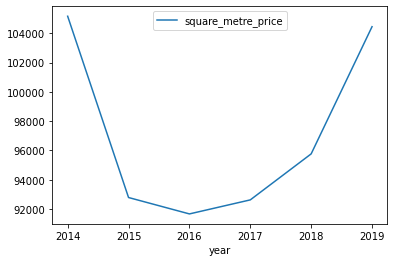

In [33]:
pivot_year = good_data.pivot_table(index = 'year', values = 'square_metre_price', aggfunc = ['count','median'])
pivot_year.plot(y='median')
pivot_year

__Выводы по корреляции стоимости квадратного метра и других характеристик недвижимости__

1) Самая сильная корреляция между ценой и стоимостью квадратного метра. Можно считать эти результаты дублирующими.

2) Есть прямая зависимость между стоимостью квадратного метра и площадью объекта. Чем выше площадь объекта, тем выше цена. 

3) Есть прямая зависимость между стоимостью квадратного метра и близостью к центру.Чем меньше расстояние до центра города, тем выше цена квадратного метра.

4) Остальные коррляции можно считать либо очень слабыми, либо отсутсвующими.

5) Самым дешевым является первый этаж. За ним следует последний. Квартиры на других этажах имеют большую стоимость при прочих равных.

6) Самые "дорогие" объявления обычно размещаюся в начале недели.К выходным цена падает.

7) На протяжении года стоимость квадратного метра колеблется. Она имеет тенденцию на снижению весной, достигает пиковых значений летом и снижается осенью, слегка "подпрыгивая" к концу года.

8) На протяжение всего наблюдаемого периода стоимость квадратного метра неуклонно растёт. Ускорее темпов роста наблюдается с 2019, когда цена год к году прибавила порядка 10%. 

5. Определим самые часто всречающиеся локации в нашей выборке и определим, где самый дорогой квадратный метр, а где самый дешевый.

,count,median
locality_name,,
Санкт-Петербург,12744,103000.000000
посёлок Мурино,482,85697.390514
посёлок Шушары,372,76343.750000
Всеволожск,309,65454.545455
Пушкин,291,97938.144330
Колпино,276,74421.542553
деревня Кудрово,267,91666.666667
посёлок Парголово,266,92097.069597
Гатчина,245,66666.666667


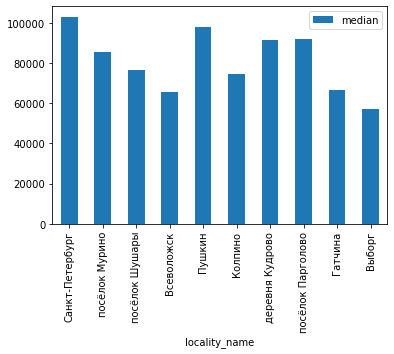

In [34]:
locality_pivot = good_data.pivot_table(index = 'locality_name', values = 'square_metre_price', aggfunc= ['count', 'median'])
locality_pivot.columns = ['count', 'median']
locality_pivot = locality_pivot.sort_values('count', ascending=False).head(10)
locality_pivot.plot(y='median', kind='bar')
locality_pivot

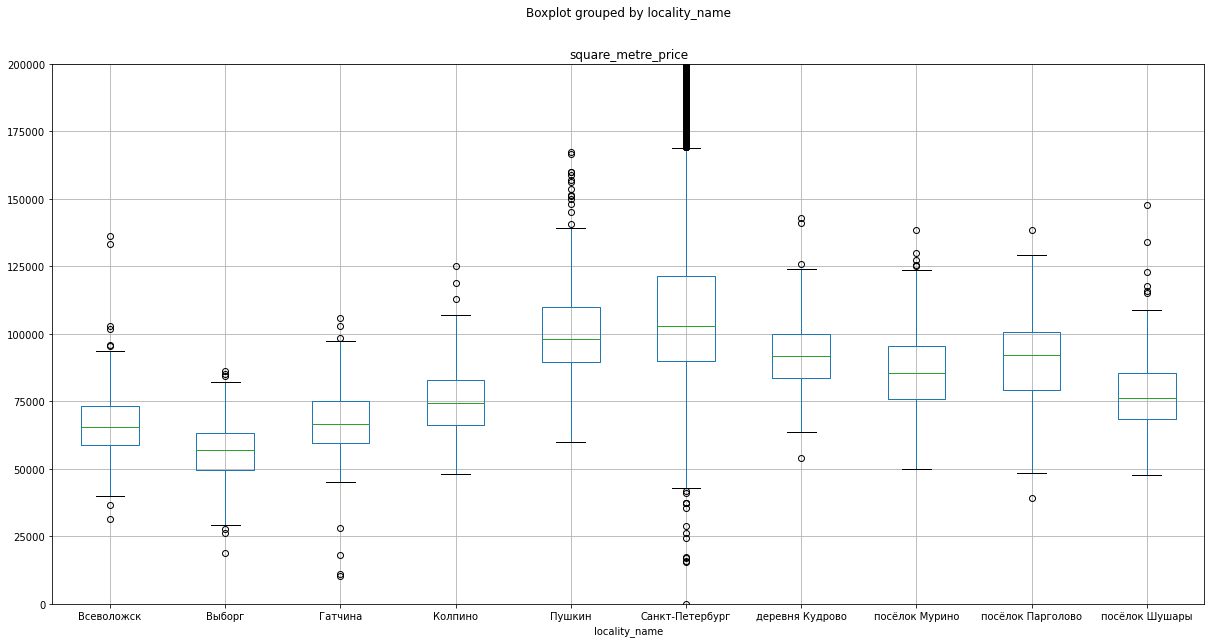

In [36]:
ax = (good_data
    .query('locality_name in @locality_pivot.index')
    .boxplot('square_metre_price', by='locality_name', figsize=(20, 10))
)
ax.set_ylim(0, 200000);

__Локации и стоимость квадратного метра__

Самая высокая стоимость квадратного метра в Санкт-Петербурге и Пушкине. Им несколько уступают Кудрово, Парголово и Мурино.

6. Определим стоимость квадратного метра в зависимсоти от близости к центру в Санкт-Петербурге.

,square_metre_price
cityCenters_nearest_km,
0,187324.130319
1,166603.755531
2,146662.860056
3,129416.344615
4,137475.497055
5,146979.232519
6,152277.893519
7,141399.731456
8,120581.349830


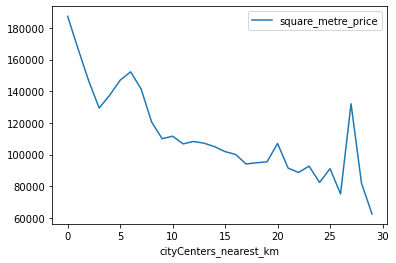

In [37]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000 
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(9999)
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')
pivot_km = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km != 9999').pivot_table(index ='cityCenters_nearest_km', values='square_metre_price', aggfunc='mean')
pivot_km.plot()
pivot_km

__Изменение стоимости квадратного метра в зависимости от удалённости от центра Санкт-Петербурга__

После 7-го киломметра стоимость квадрата резко падает. Можно предположить, что именно эта зона является центром города.

7. Теперь проанализируем квартиры в центре Петербурга и определим, отличаются ли факторы, влияющие на ценообразование для этого региона по сравнению со всей выборкой.

За центр, как следует из предыдущего пункта, мы будем принимать район от 0 до 7 км включительно.

Мы проанализируем специфику объектов недвижимости в центре по следующим параметрам: стоимость продажи, общая площадь, количество комнат и высота потолков. Теже самые процедуры мы применили ко всей выборке в пункте 4.1. 

count    3712.000000
mean       92.328303
std        60.531664
min        12.000000
25%        56.000000
50%        77.760000
75%       108.725000
max       900.000000
Name: total_area, dtype: float64

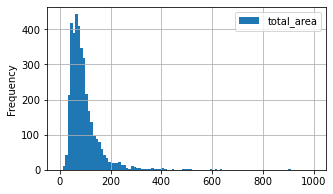

In [38]:
spb_centre_data = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km <= 7')
spb_centre_data.plot(y = 'total_area', kind='hist', bins=100, grid=True, figsize=(5,3), range=(0,1000))
spb_centre_data['total_area'].describe()

count    3.712000e+03
mean     1.472962e+07
std      2.470451e+07
min      1.600000e+06
25%      6.590000e+06
50%      9.000000e+06
75%      1.413138e+07
max      7.630000e+08
Name: last_price, dtype: float64

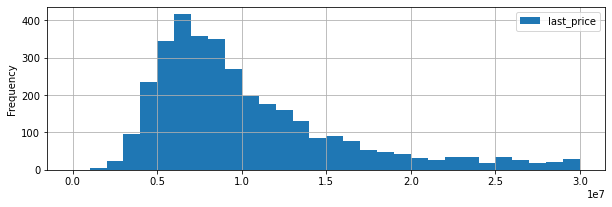

In [39]:
spb_centre_data.plot(y = 'last_price', kind='hist', bins=30, grid=True, figsize=(10,3), range=(0,30000000))
spb_centre_data['last_price'].describe()

count    3712.000000
mean        2.813308
std         1.456235
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        19.000000
Name: rooms, dtype: float64

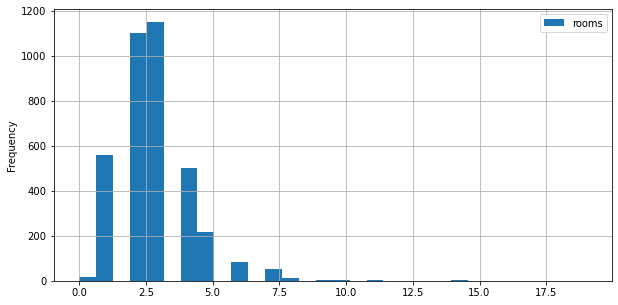

In [40]:
spb_centre_data.plot(y = 'rooms', kind='hist', bins=30, grid=True, figsize=(10,5))
spb_centre_data['rooms'].describe()

count    3712.000000
mean        2.986251
std         0.706277
min         2.000000
25%         2.771499
50%         2.800000
75%         3.102500
max        32.000000
Name: ceiling_height, dtype: float64

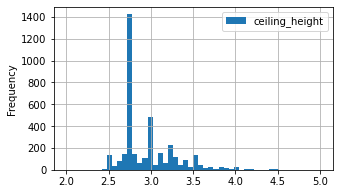

In [41]:
spb_centre_data.plot(y = 'ceiling_height', kind='hist', bins=50, grid=True, figsize=(5,3), range=(2,5))
spb_centre_data['ceiling_height'].describe()

__Вывод по специфике объектов недвижимости в центре Санкт-Петербурга__

1. Средняя площадь недвижимости в центре - 90 квадратных метров. Это в полтора раза больше, чем в среднем по всей выборке.

2. Средняя стоимость объекта в центре составляет 14.5 млн. что в два с лишним раза превосходит среднее значение по всей выборке - 6.5 млн. 

3. В центре Санкт-Петербурга преобладают квартиры с 3-мя комнатами, им слегка уступают "двушки". В то время, как в основной выборке доминируют предложения по "однушкам" и "двушкам".

4. Величина потолка в центре - почти 3 метра, что побольше, чем в среднем по выборке. 

Средний объект невдвижимости в центре Санкт-Петербурга - это трёхкомнатная квратира, около 90 квадратных метров, с выоским потолком, парком и водоёмом в пещей доступности. Но и цена у такого объекта порядка 14,5 млн.

In [42]:
corr_spb_data = data.corr()
corr_spb_data['square_metre_price'].sort_values(ascending=False)

square_metre_price        1.000000
last_price                0.736499
kitchen_area              0.397493
total_area                0.301960
living_area               0.226346
ponds_around3000          0.191039
parks_around3000          0.185163
kithcen_space_ratio       0.158369
floors_total              0.148098
total_images              0.132780
floor                     0.129068
ceiling_height            0.096725
rooms                     0.055420
is_apartment              0.044725
balcony                   0.023376
days_exposition           0.020332
studio                    0.015636
year                      0.008516
open_plan                 0.008266
parks_nearest             0.006933
month                    -0.001995
day                      -0.007272
airports_nearest         -0.038734
ponds_nearest            -0.104974
living_space_ratio       -0.149427
cityCenters_nearest      -0.317951
cityCenters_nearest_km   -0.404932
Name: square_metre_price, dtype: float64

__Интерпретация значений корреляции__

- Видим высокую прямую корреляцию между стоимостью квадратного метра и стоимостью объекта. В дорогих объектах дорогой квадрат. 

- Умеренная прямая корреляция наблюдается между площадью кухни и общей площадью, с одной стороны, и стоимостью квадрата с другой. Чем больше площадь(общая или кухни), тем выше цена.

- Умеренная обратная корреляция существует между стоимостью квадрата и близостью центра города. Чем меньше расстояние о центра, тем выше стоимость квадратного метра. 

- Слабая прямая коррелция также наблюдается с такими характеристиками, как: жилая площадь, наличие в радиусе 3 км парков и прудов, отношением площади кухни к площади всего объекта, этажностью дома, этажом объекта, количеством изображений. А вот высота птолков,  отличии от общей выборки, из этого списка выпала.

- Слабая обратная корреляция наблюдается между стоимостью квадратного метра и отношением жилой площади к площади всей квартиры. Также слабая зависимомть появилась между расстоянием до ближайшего водоёма и стоимостью квадрата. Однако для центра Санк-Петербурга, с его каналами и прудами и Невой, это выглядит, скорее, как совпадение.  

Посмотрим на взимосвязь ключевых характеристик со стоимостью квадрата на разных графиках. 
Начнём с общей площади объекта.

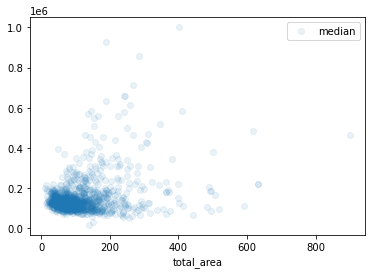

In [43]:
pivot_spb_area = spb_centre_data.pivot_table(index='total_area', values='square_metre_price', aggfunc=['count', 'mean', 'median'])
pivot_spb_area.columns = ['count', 'mean', 'median']
pivot_spb_area.plot(y='median', style= 'o', alpha = 0.09);

График подтверждает данные таблицы с корреляциями.

Построим график для количества комнат и стоимости квадрата.

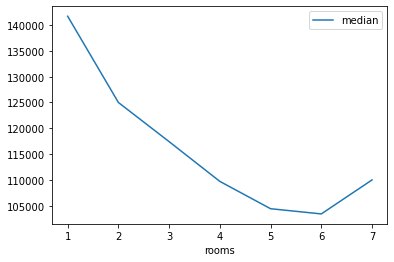

In [44]:
pivot_spb_rooms = spb_centre_data.pivot_table(index='rooms', values='square_metre_price', aggfunc=['count', 'mean', 'median'])
pivot_spb_rooms.columns = ['count', 'mean', 'median']
pivot_spb_rooms.query('count > 50').plot(y='median');

Для центра Санкт-Петербурга гораздо отчётливей видим тренд на снижение цены, в зависимости от количества комнат. Квартиры с 6-ю комнатами покупать выгодне всего.

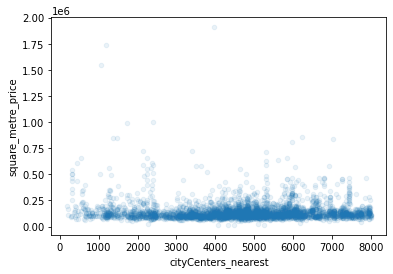

In [45]:
spb_centre_data.plot(x='cityCenters_nearest', y='square_metre_price', kind='scatter', alpha=0.09);

На графике видим, что для центрального района приближение к "нулевому километру" не столь актально. 

Отдельно посчитаем взаимосвязь стоимости квадрата в центре Санкт-Петербурга и этажности.

,count,median
,square_metre_price,square_metre_price
floor_category,,
Другой,2653,127551.020408
Первый,407,108653.846154
Последний,652,116873.156342


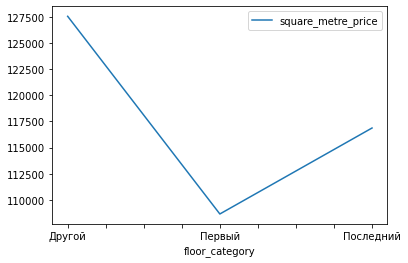

In [46]:
pivot_spb_floor_category = spb_centre_data.pivot_table(index = 'floor_category', values = 'square_metre_price', aggfunc = ['count','median'])
pivot_spb_floor_category.plot(y='median')
pivot_spb_floor_category

Посчитаем взаимосвязь стоимости квадрата в центре Санкт-Петербурга от даты публикации объявления: дня, месяца и года

,count,median
,square_metre_price,square_metre_price
day,,
0,560,125816.438787
1,631,120930.232558
2,637,124590.163934
3,763,121328.224777
4,629,124705.882353
5,282,128567.538126
6,210,129122.870605


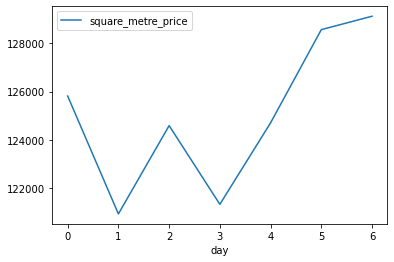

In [47]:
pivot_spb_day = spb_centre_data.pivot_table(index = 'day', values = 'square_metre_price', aggfunc = ['count','median'])
pivot_spb_day.plot(y='median')
pivot_spb_day

,count,median
,square_metre_price,square_metre_price
month,,
1,226,130366.972477
2,406,121355.287326
3,395,130890.052356
4,350,126337.691844
5,208,122336.834209
6,303,119736.842105
7,288,118922.668759
8,273,125714.285714


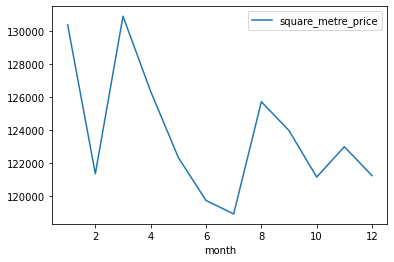

In [48]:
pivot_spb_month = spb_centre_data.pivot_table(index = 'month', values = 'square_metre_price', aggfunc = ['count','median'])
pivot_spb_month.plot(y='median')
pivot_spb_month

,count,median
,square_metre_price,square_metre_price
year,,
2014,27,143465.553236
2015,328,119102.173434
2016,522,119047.619048
2017,1331,121698.113208
2018,1103,124742.268041
2019,401,135614.179720


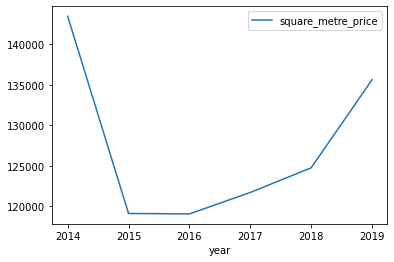

In [49]:
pivot_spb_year = spb_centre_data.pivot_table(index = 'year', values = 'square_metre_price', aggfunc = ['count','median'])
pivot_spb_year.plot(y='median')
pivot_spb_year

__Вывод о факторах, вдияющих на стоимость квадратного метра в центе Санк-Петербурга__

1) Самая сильная прямая корреляция наблюдается между стоимостью квадрата и площадью. Чем больше площадь квартиры, тем выше стоимость.

2) Для выборки по центру Санкт-Петербурга весомой является корреляция стоимости квадрата и приближением к "нулевому киллометру".

3) Остальные характеристики можно считать не оказывающими влияние на выборку.

4) В центре Санкт-Петербурга, также как и в основной выборке, самым дешевым является первый этаж. За ним идёт последний этаж. Самые дорогие - этажи со второго до предпоследнего. Но, в Санкт-Петербурге разница в стоимости между этажами чуть меньше, чем в целом по выборке.

5) В Санкт-Петербурге самая высокая стоимость квадратного метра отмечается в конце недели - в субботу и воскресенье - а не в начале недели, как в основной выборке.

6) В Санкт-Петербурге наблюдается и отличная от основной выборки "сезонность". Самая высокая стоимость квадрата приходится на первые месяцы года, за исключеникм февраля. К лету стоимость падает и слегка поднимается к осени.

7) В отличие от основной выборки, в центре Санкт-Петербурга к 2015 году можно отметить падение стоимости квадратного метра. Начиная с 2016 года виден тренд на рост. Однако темпы роста цен здесь ниже, чем в целом повыборке. Можно сказать, что спальные районы и область в рассматриваемый период старались догнать по ценам центр. 

## Общий вывод

### Предоброботка данных

- Выявили пропуски в данных.

- Там где это было уместно, заменили. Высоту потолка - средним значением, которое составило 2.77.

- Убрали выбросы на 45, 60 и 90 в 'days_exposition'. Выбросы составили 6,8%. 

- Природу выбросов в 'days_exposition' нужно уточнить отдельно. 

### Дополнитльные расчёты

- Ввели столбец со стоимостью квадратного метра для каждого объекта.

- Добавили столбцы с днём, месяцем и годом подачи объявления, чтобы отследить изменение цены по времени.

- Расчитали и добавили в таблицу категоризацию этажности: первый, последний, другой.

- Посчитали отношение жилой площади и кухни к общей. Результаты получили отраженеи в датафрейме.

- Определили десять самых частовстречающихся локации в выборке.

- Определили стоимость самой дорогой локации в выборке.

- Определили центр Санкт-Петербурга - от 0 до 7 км. включительно.


### Анализ данных

#### По всей выборке

- Средняя площадь объекта недвижимости - 60.3 кв.м.

- Средняя цена объекта - 6.5 млн.

- Среднее количество комнат - 2. 

- Средняя высота потолка - 2.77 м.

- Среднее время продажи квартиры составляет 109 дней.

- Если сделка была совершенна не позднее 33 дней с момента публикации объявления, то её можно считать очень быстрой. 

- Если позже 165 дня - то аномально долгой. 

- На стоимость квадратного мтера сильнее всего влияют:  площадю кухни и общяя площадь.

- Умеренно влияет близость к центру города.

- Слабао влияют: жилая площадь, наличие в радиусе 3 км парков и прудов, отношением площади кухни к площади всего объекта, этажность дома, этаж объекта, количеством изображений, высота потолков.

- Самый дорогой кв.м в однушках и квартирах с 7-ю и более комнатами.

- Стоимость кв.м на первых этажах самая низкая. Чуть больше стоимость на последнем этаже.

- Самая высокая стоимость кв.м в объявлениях, орубликованных в середине недели.

- Весной стоимость квартир снижается. 

- Летом стоимость квартир достигает пиковых значений, но снижается осенью. Небольшой всплеск в стоимости отмечается к концу года.

- Есть тренд на рост стоимости квартир. Темпы роста особенно ускорились в 2019 году.

- Самая высокая стоимость квадратного метра в Санкт-Петербурге и Пушкине. Им несколько уступают Кудрово, Парголово и Мурино.


#### По центру Санк-Петербурга

- Средняя площадь недвижимости в центре - 90 квадратных метров. 

- Средняя стоимость объекта в центре составляет 14.5 млн. 

- В центре Санкт-Петербурга преобладают квартиры с 3-мя комнатами, им слегка уступают "двушки". 

- Величина потолка в центре - 2.98 м.

- На стоимость квадратног ометра умеренно влияют: площадь кухни и общяя площадью.

- Умеренная обратная корреляция существует между стоимостью квадрата и близостью центра города. 

- Слабая прямая коррелция также наблюдается с такими характеристиками, как: жилая площадь, наличие в радиусе 3 км парков и прудов, отношением площади кухни к площади всего объекта, этажностью дома, этажом объекта, количеством изображений. 

- Слабая обратная корреляция наблюдается между стоимостью квадратного метра и отношением жилой площади к площади всей квартиры,а также расстоянием до ближайшего водоёма и стоимостью квадрата (что, скорее всего, является совпадением).

- Самый дорогой кв.м. в "однушках".

- Самый дешёвый - в 5-ти и 6-ти комнатных квартирах. 

- Самый дешёвый этаж - первый. За ним следует последний. 

- Объявления с самыми дорогими предложениями в Петербурге публикуются в конце недели - в субботу и воскресенье.

- Пик стоимости кв.м. приходится на начало года. Кроме февраля. 

- К середине лета обычно идёт спад. За тем наступает подъём до середины осени.

- В 2014 году в Санкт-Петербурге произошло падение стоимости кв.м.

- С 2016 года наметился рост, но средних значений 2014 года кв.м не достиг.